<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/CompareIDRSPPValues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#read in column 7 (for signal strength) and column 12 (global IDR, which is
# used for thresholding: https://groups.google.com/forum/#!topic/idr-discuss/FY2K5VKx8AQ)
#ChIP-seq pipeline documentation including description of IDR columns is here:
# https://docs.google.com/document/d/1lG_Rd7fnYgRpSIqrIfuVlAz2dW1VaSQThzk836Db99c/edit

import gzip
import numpy as np

#download ENCSR000AKO Pooled pseudorep full IDR list (CTCF in K562)
![[ -f ENCSR000AKO_idr_PPR.gz ]] || wget "https://drive.google.com/uc?export=download&id=19xt-LnHDLfEhsP_ID9LeacFaC8c6C9bt" -O ENCSR000AKO_idr_PPR.gz

idr_peak_file = 'ENCSR000AKO_idr_PPR.gz'

signal_strength, signal_confidence = zip(*[(float(x.decode('utf-8').rstrip().split("\t")[6]),
                                            float(x.decode('utf-8').rstrip().split("\t")[11]))
                                            for x in gzip.open(idr_peak_file,'rb')])

signal_strength, signal_confidence = np.array(signal_strength), np.array(signal_confidence)


--2018-12-10 06:10:44--  https://drive.google.com/uc?export=download&id=19xt-LnHDLfEhsP_ID9LeacFaC8c6C9bt
Resolving drive.google.com (drive.google.com)... 108.177.112.100, 108.177.112.102, 108.177.112.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.112.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1j8484a9r27rafv0lbn6lhueckai7362/1544421600000/00395683668588961264/*/19xt-LnHDLfEhsP_ID9LeacFaC8c6C9bt?e=download [following]
--2018-12-10 06:10:45--  https://doc-00-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1j8484a9r27rafv0lbn6lhueckai7362/1544421600000/00395683668588961264/*/19xt-LnHDLfEhsP_ID9LeacFaC8c6C9bt?e=download
Resolving doc-00-50-docs.googleusercontent.com (doc-00-50-docs.googleusercontent.com)... 108.177.112.132, 2607:f8b0:4001:c12::84
Connecting to doc-00-50-docs.googleusercontent.com (d

42385


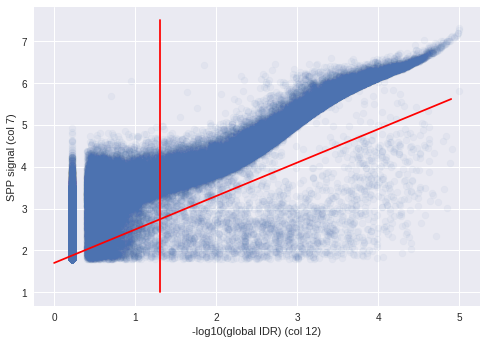

1954
40431


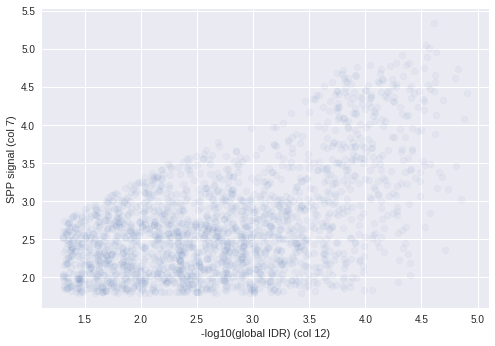

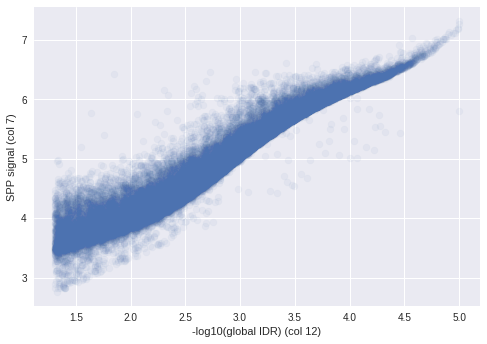

In [2]:
from matplotlib import pyplot as plt

slope=0.8
intercept=1.7
pvalthresh = -np.log(0.05)/np.log(10)

plt.scatter(signal_confidence, np.arcsinh(signal_strength), alpha=0.05)
plt.plot([pvalthresh,pvalthresh], [1,7.5], color="red")
plt.plot(np.arange(0,5,0.1),slope*np.arange(0,5,0.1)+intercept, color="red")
print(np.sum(signal_confidence > pvalthresh))
plt.xlabel("-log10(global IDR) (col 12)")
plt.ylabel("SPP signal (col 7)")
plt.show()

category1 = (signal_confidence > pvalthresh)*(np.arcsinh(signal_strength) <= (signal_confidence*slope + intercept))
category2 = (signal_confidence > pvalthresh)*(np.arcsinh(signal_strength) > (signal_confidence*slope + intercept))

print(np.sum(category1))
print(np.sum(category2))

plt.scatter(signal_confidence[category1], np.arcsinh(signal_strength)[category1], alpha=0.05)
plt.xlabel("-log10(global IDR) (col 12)")
plt.ylabel("SPP signal (col 7)")
plt.show()

plt.scatter(signal_confidence[category2], np.arcsinh(signal_strength)[category2], alpha=0.05)
plt.xlabel("-log10(global IDR) (col 12)")
plt.ylabel("SPP signal (col 7)")
plt.show()



In [3]:
!pip install pyfasta
!pip install deeptools
!pip uninstall momma_dragonn
!git clone https://github.com/kundajelab/momma_dragonn
!pip install ./momma_dragonn
!rm -rf momma_dragonn

!apt-get install bedtools
  
#Get hg38 fasta by download 2bit and then converting to fa
![[ -f hg38.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit -O hg38.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg38.genome.fa ]] || ./twoBitToFa hg38.2bit hg38.genome.fa
  
#download hg38 chromsizes file
![[ -f hg38.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O hg38.chrom.sizes

  Running setup.py bdist_wheel for pyfasta ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ef/57/33/7b569168243dfbfe60bd3533e6897d170b391f2ce58df9d275
Successfully built pyfasta
    100% |████████████████████████████████| 3.3MB 10.2MB/s 
    100% |████████████████████████████████| 9.7MB 4.7MB/s 
    100% |████████████████████████████████| 71kB 17.6MB/s 
    100% |████████████████████████████████| 37.8MB 894kB/s 
    100% |████████████████████████████████| 3.1MB 14.6MB/s 
    100% |████████████████████████████████| 71kB 26.3MB/s 
    100% |████████████████████████████████| 552kB 25.9MB/s 
    100% |████████████████████████████████| 8.1MB 5.9MB/s 
  Running setup.py bdist_wheel for deeptools ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/26/7b/1a/e828c248cbb05db00a41118e24c0435bcdbf1b750f4dd2c0c8
  Running setup.py bdist_wheel for numpydoc ... - done
  Stored in directory: /root/.cache/pip/wheels/ea/55/7f/3e25d754760c

In [4]:
#do an asinh transform of column 7 (SPP singal strength)
!zcat ENCSR000AKO_idr_PPR.gz | perl -lane 'BEGIN{use Math::Trig} {print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))."\t".asinh($F[6])."\t".$F[11]}' | bedtools slop -g hg38.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1\t$F[3]\t".$F[4]}' | sortBed | gzip -c > positives_hybridbnc_asinh_spp.gz

import os
import sys
import gzip
from collections import OrderedDict

def tile_across_genome(chrom_sizes_file,
                       chroms_to_exclude,
                       out_file, bin_sizes,
                       bin_stride):

    chromosome_sizes = OrderedDict()
    for line in open(chrom_sizes_file):
        chrom, size = line.rstrip().split("\t")
        if (("_" not in chrom) and
            (chrom not in chroms_to_exclude)):
            size = int(size)
            chromosome_sizes[chrom] = size 
        else:
            pass
            #print("Dropping chrom",chrom)

    outfile = open(out_file, "w")
    
    for a_chrom in chromosome_sizes:
        the_end = chromosome_sizes[a_chrom] 
        bin_start = 0
        while ((bin_start + bin_sizes) < the_end):
            outfile.write(a_chrom+"\t"+str(bin_start)
                          +"\t"+str(bin_start+bin_sizes)+"\n")
            bin_start += bin_stride

    outfile.close()

if (os.path.isfile("1kb_tiles.bed")==False):
  print("Tiling across the genome in 1kb windows")
  tile_across_genome(out_file = "1kb_tiles.bed",
                     chrom_sizes_file="hg38.chrom.sizes",
                     bin_sizes=1000,
                     bin_stride=1000,
                     chroms_to_exclude=["chrM"])    

  
# Negative set: 1kb regions tiling across the genome that do not overlap any of the peaks in the idr file
!bedtools intersect -sorted -v -a 1kb_tiles.bed -b positives_hybridbnc_asinh_spp.gz -wa | perl -lane 'print $F[0]."\t".$F[1]."\t".$F[2]."\t0\t0\t0"' | gzip -c > negative_regions.gz
!zcat positives_hybridbnc_asinh_spp.gz negative_regions.gz | sortBed | gzip -c > hybridbnc_asinh_spp_labels.gz

#train-test-valid splits
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_hybridbnc_asinh_spp_labels.gz
!zcat test_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_test_hybridbnc_asinh_spp_labels.gz
!zcat test_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_test_hybridbnc_asinh_spp_labels.gz
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w 'chr22' | gzip -c > valid_hybridbnc_asinh_spp_labels.gz
!zcat valid_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_valid_hybridbnc_asinh_spp_labels.gz
!zcat valid_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_valid_hybridbnc_asinh_spp_labels.gz
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w -v 'chr1|chr8|chr21|chr22' | gzip -c > train_hybridbnc_asinh_spp_labels.gz
!zcat train_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_train_hybridbnc_asinh_spp_labels.gz
!zcat train_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_train_hybridbnc_asinh_spp_labels.gz


Tiling across the genome in 1kb windows


In [5]:
from keras.models import load_model
from keras.models import Model

from collections import OrderedDict
import numpy as np

import keras
from keras.models import Model
from momma_dragonn.data_loaders import pyfasta_data_loader
import six

def get_single_stream_data_generator(**kwargs):

  return pyfasta_data_loader.SingleStreamSeqOnly(
               fasta_data_source="hg38.genome.fa",
               rc_augment=True,
               num_to_load_for_eval=100, #not used
               labels_dtype="float",
               wrap_in_keys=["sequence", "output"],
               randomize_after_pass=True,
               **kwargs)

def iterate_over_generator_in_batches(batch_size, generator):
  X_batch = []
  y_batch = []
  for (X_ex, y_ex, coor, fastastr) in generator:
    X_batch.append(X_ex)
    y_batch.append(y_ex)
    if (len(X_batch)==batch_size):
      yield np.array(X_batch), np.array(y_batch)
      X_batch = []
      y_batch = []
  if (len(X_batch) > 0):
    yield np.array(X_batch), np.array(y_batch)
    
def get_predictions_and_true_labels(bed_source, labels_subset, name_to_model): 
  generator = pyfasta_data_loader.SingleStreamSeqOnly(
     batch_size=None,
     bed_source=bed_source,
     labels_subset=labels_subset,
     fasta_data_source="hg38.genome.fa",
     rc_augment=True,
     num_to_load_for_eval=None, #not used
     labels_dtype="float",
     wrap_in_keys=["sequence", "output"],
     randomize_after_pass=False).get_generator(loop_infinitely=False)  
  name_to_predictions = OrderedDict()
  true_y = []
  for X_batch, y_batch in iterate_over_generator_in_batches(
                            batch_size=200, generator=generator):
    true_y.extend(y_batch)
    for name in name_to_model:
      if name not in name_to_predictions:
        name_to_predictions[name] = []
      name_to_predictions[name].extend(name_to_model[name].predict(
                                       {'sequence': X_batch}))
  for name in name_to_predictions:
    name_to_predictions[name] = np.array(name_to_predictions[name])
  return np.array(true_y), name_to_predictions

#load pretrained binary model
![[ -f binary_model_2018Nov28_0136pm.h5 ]] || wget "https://drive.google.com/uc?export=download&id=1-3p_mB6QBGxnYdnpiQx1etfKZM8i8Xxk" -O binary_model_2018Nov28_0136pm.h5
#load pretrained regression model
![[ -f positives_asinh_spp_model_2018Nov28_0908am_chromosomeholdout.h5 ]] || wget "https://drive.google.com/uc?export=download&id=13pYwgbmv8F5aHQvWkcaj-XtXnCRqnRN5" -O positives_asinh_spp_model_2018Nov28_0908am_chromosomeholdout.h5


binary_model = load_model("binary_model_2018Nov28_0136pm.h5")
binary_preact_model = Model(inputs=binary_model.layers[0].input,
                            outputs=binary_model.layers[-2].output)
positives_asinh_spp_model = load_model("positives_asinh_spp_model_2018Nov28_0908am_chromosomeholdout.h5")

positives_asinh_spp_name_to_model = {'positives_asinh_spp_model': positives_asinh_spp_model,
                                     'binary_preact_model': binary_preact_model}

#verify no train-test contamination!
!bedtools intersect -sorted -a positives_test_hybridbnc_asinh_spp_labels.gz -b positives_train_hybridbnc_asinh_spp_labels.gz | wc -l
!bedtools intersect -sorted -a positives_test_hybridbnc_asinh_spp_labels.gz -b positives_valid_hybridbnc_asinh_spp_labels.gz | wc -l


test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="positives_test_hybridbnc_asinh_spp_labels.gz",
    labels_subset=[1,2],
    name_to_model=positives_asinh_spp_name_to_model)

Using TensorFlow backend.


--2018-12-10 06:13:25--  https://drive.google.com/uc?export=download&id=1-3p_mB6QBGxnYdnpiQx1etfKZM8i8Xxk
Resolving drive.google.com (drive.google.com)... 108.177.112.139, 108.177.112.113, 108.177.112.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.112.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cascgsbovln9bhluc4go6a4vbgofk0v3/1544421600000/00395683668588961264/*/1-3p_mB6QBGxnYdnpiQx1etfKZM8i8Xxk?e=download [following]
--2018-12-10 06:13:26--  https://doc-04-50-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cascgsbovln9bhluc4go6a4vbgofk0v3/1544421600000/00395683668588961264/*/1-3p_mB6QBGxnYdnpiQx1etfKZM8i8Xxk?e=download
Resolving doc-04-50-docs.googleusercontent.com (doc-04-50-docs.googleusercontent.com)... 108.177.112.132, 2607:f8b0:4001:c12::84
Connecting to doc-04-50-docs.googleusercontent.com (d

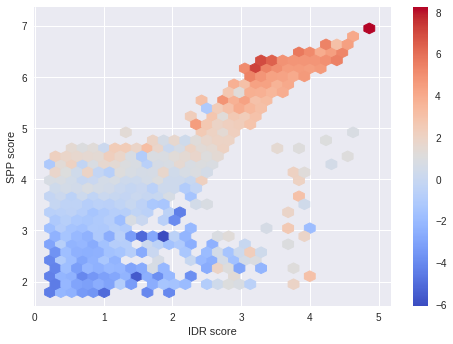

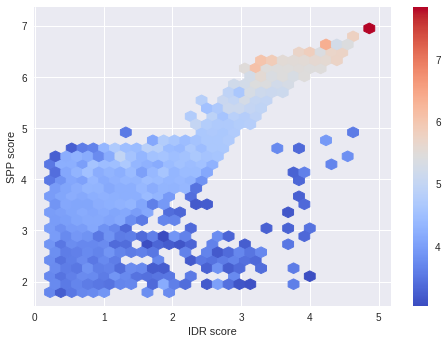

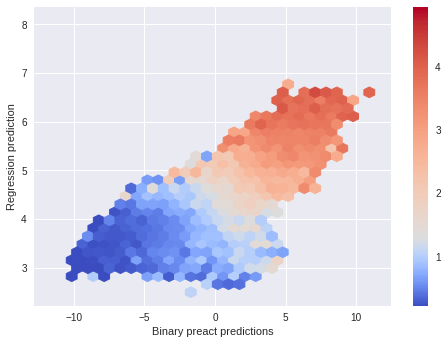

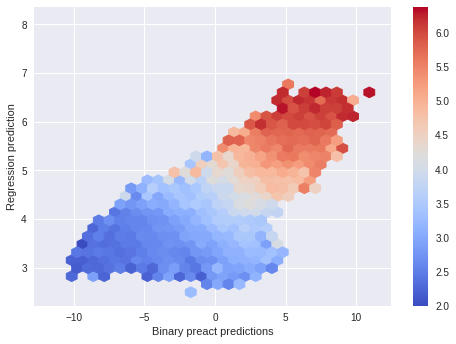

In [45]:
test_positives_asinh_spp_y.shape
test_positives_asinh_spp_name_to_predictions['positives_asinh_spp_model'].shape


from matplotlib import pyplot as plt
from matplotlib import colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

      
      
hb = plt.hexbin(
    test_positives_asinh_spp_y[:,1],
    test_positives_asinh_spp_y[:,0],
    C=test_positives_asinh_spp_name_to_predictions['binary_preact_model'][:,0],
    reduce_C_function=lambda x: np.mean(x),
    mincnt=1,
    cmap="coolwarm",
    gridsize=30)
plt.colorbar(hb)
plt.xlabel("IDR score")
plt.ylabel("SPP score")
plt.show()
      
      
    
hb = plt.hexbin(
    test_positives_asinh_spp_y[:,1],
    test_positives_asinh_spp_y[:,0],
    C=test_positives_asinh_spp_name_to_predictions['positives_asinh_spp_model'][:,0],
    reduce_C_function=lambda x: np.mean(x),
    mincnt=1,
    cmap="coolwarm",
    gridsize=30)
plt.colorbar(hb)
plt.xlabel("IDR score")
plt.ylabel("SPP score")
plt.show()     
      
      
hb = plt.hexbin(
    test_positives_asinh_spp_name_to_predictions['binary_preact_model'][:,0],
    test_positives_asinh_spp_name_to_predictions['positives_asinh_spp_model'][:,0],
    C=test_positives_asinh_spp_y[:,1],
    reduce_C_function=lambda x: np.mean(x),
    mincnt=1,
    cmap="coolwarm",
    norm=MidpointNormalize(vmin=np.min(test_positives_asinh_spp_y[:,1]),
                           vmax=np.max(test_positives_asinh_spp_y[:,1]),
                           midpoint=-np.log(0.05)/np.log(10)),
    gridsize=30)
plt.colorbar(hb)
plt.xlabel("Binary preact predictions")
plt.ylabel("Regression prediction")
plt.show()

hb = plt.hexbin(
    test_positives_asinh_spp_name_to_predictions['binary_preact_model'][:,0],
    test_positives_asinh_spp_name_to_predictions['positives_asinh_spp_model'][:,0],
    C=test_positives_asinh_spp_y[:,0],
    reduce_C_function=lambda x: np.mean(x),
    mincnt=1,
    cmap="coolwarm",
    gridsize=30)
plt.colorbar(hb)
plt.xlabel("Binary preact predictions")
plt.ylabel("Regression prediction")
plt.show()

#Start with simple 3-class classification;
#'ambiguous' for every peaks with -log10(global IDR) < 2
#class 0 is for negatives
#class 1 is 

In [15]:
np.min(test_positives_asinh_spp_y,axis=0)

array([1.79174109, 0.22      ])

In [35]:
dir(hb.colorbar)

['_A',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_solids',
 '_boundaries',
 '_central_N',
 '_config_axes',
 '_edges',
 '_extend_lower',
 '_extend_upper',
 '_extended_N',
 '_find_range',
 '_get_extension_lengths',
 '_inside',
 '_label',
 '_labelkw',
 '_locate',
 '_mesh',
 '_outline',
 '_patch_ax',
 '_process_values',
 '_proportional_y',
 '_set_label',
 '_slice_dict',
 '_tick_data_values',
 '_ticker',
 '_uniform_y',
 '_values',
 '_y',
 'add_checker',
 'add_lines',
 'alpha',
 'autoscale',
 'autoscale_None',
 'ax',
 'boundaries',
 'callbacksSM',
 'changed',
 'check_update',
 'cmap',
 'colorbar',
 'config_axis',
 'dividers',
 'draw_all',
 'drawedges',
 'extend',


In [39]:
hb.colorbar._values

array([1.99725605, 2.01458937, 2.03192268, 2.049256  , 2.06658931,
       2.08392263, 2.10125594, 2.11858926, 2.13592257, 2.15325589,
       2.1705892 , 2.18792252, 2.20525584, 2.22258915, 2.23992247,
       2.25725578, 2.2745891 , 2.29192241, 2.30925573, 2.32658904,
       2.34392236, 2.36125568, 2.37858899, 2.39592231, 2.41325562,
       2.43058894, 2.44792225, 2.46525557, 2.48258888, 2.4999222 ,
       2.51725552, 2.53458883, 2.55192215, 2.56925546, 2.58658878,
       2.60392209, 2.62125541, 2.63858872, 2.65592204, 2.67325536,
       2.69058867, 2.70792199, 2.7252553 , 2.74258862, 2.75992193,
       2.77725525, 2.79458856, 2.81192188, 2.8292552 , 2.84658851,
       2.86392183, 2.88125514, 2.89858846, 2.91592177, 2.93325509,
       2.9505884 , 2.96792172, 2.98525503, 3.00258835, 3.01992167,
       3.03725498, 3.0545883 , 3.07192161, 3.08925493, 3.10658824,
       3.12392156, 3.14125487, 3.15858819, 3.17592151, 3.19325482,
       3.21058814, 3.22792145, 3.24525477, 3.26258808, 3.27992

In [24]:
hb

In [25]:
dir(hb.cmap)

['N',
 '__call__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_gamma',
 '_i_bad',
 '_i_over',
 '_i_under',
 '_init',
 '_isinit',
 '_lut',
 '_resample',
 '_rgba_bad',
 '_rgba_over',
 '_rgba_under',
 '_segmentdata',
 '_set_extremes',
 'colorbar_extend',
 'from_list',
 'is_gray',
 'monochrome',
 'name',
 'reversed',
 'set_bad',
 'set_gamma',
 'set_over',
 'set_under']

In [31]:
hb.cmap._segmentdata

{'blue': [(0.0, 0.753683153, 0.753683153),
  (0.03125, 0.801466763, 0.801466763),
  (0.0625, 0.84495867, 0.84495867),
  (0.09375, 0.883725899, 0.883725899),
  (0.125, 0.917387822, 0.917387822),
  (0.15625, 0.945619588, 0.945619588),
  (0.1875, 0.968154911, 0.968154911),
  (0.21875, 0.98478814, 0.98478814),
  (0.25, 0.995375608, 0.995375608),
  (0.28125, 0.999836203, 0.999836203),
  (0.3125, 0.998151185, 0.998151185),
  (0.34375, 0.990363227, 0.990363227),
  (0.375, 0.976574709, 0.976574709),
  (0.40625, 0.956945269, 0.956945269),
  (0.4375, 0.931688648, 0.931688648),
  (0.46875, 0.901068838, 0.901068838),
  (0.5, 0.865395561, 0.865395561),
  (0.53125, 0.820880546, 0.820880546),
  (0.5625, 0.774508472, 0.774508472),
  (0.59375, 0.726736146, 0.726736146),
  (0.625, 0.678007945, 0.678007945),
  (0.65625, 0.628751763, 0.628751763),
  (0.6875, 0.579375448, 0.579375448),
  (0.71875, 0.530263762, 0.530263762),
  (0.75, 0.481775914, 0.481775914),
  (0.78125, 0.434243684, 0.434243684),
  (0.812